# **Action-Values Background**

## **Sample Averaging**: the easiest way to estimate the value of any particular action is to average the rewards that were received every time *this action* was taken.

[![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZGa44V1RJfQWVbsNXJN4ag.png)](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZGa44V1RJfQWVbsNXJN4ag.png)


## **Incremental Updates**: tracking the total number of rewards is not scalable, so we choose to make incremental updates using the following rule:

[![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*HoZf7HbUits8fag088ZEbg.png)](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*HoZf7HbUits8fag088ZEbg.png)

The general form of this update rule (which we've seen in our Haptics and Telerobotics and Communication Networks classes) is:
*NewEstimate ← OldEstimate + StepSize [ Target − OldEstimate ]*

This alllows us to leverage dynamic programming to make incremental updates such that we can store our action values more scalably. We will offer a discussion on the step-size parameter 1/n. This--changing--step-size parameter is to be used when tracking stationary problems such that convergence is guaranteed. WHen tracking non-stationary problems, as we will see later, using a fixed step-size parameter is needed to 'forget' older estimates and accomodate for changing true/actual action-values.

## Action Selection: Greedy and Epsilon-Greedy

We now know how to estimate the value of an action using a simple averaging technique. We must now begin by looking at two basic ways to choose an action.

**Greedy Action Selection**: Always choose the value with the highest-estimated value. This is known as always choosing the greedy action, or always exploiting.

**Epsilon-Greedy Action Selection**: Choose the greedy action most of the times but, using probability=epsilon, some other action *randomly* (as we will cover other techniques that make informed decisions on what actions should be **explored**).

## Optimistic Initial Values

How do we initialize our estimates of the action values?

1. Initialize them all to 0. Simple and works fine (this initial value makes it such that these methods are *biased* by their initial estimates.
2. Initialize them optimistically--start off with values that are wildly optimistc or much higher than they realistically would be (we're sampling from a probability distribution so these values are *realistic* but very very rare and certainly can't be a proper estimate of the expected value of these actions. This optimism encourages action-value methods to explore. Whichever actions are initially selected, the reward is less than the starting estimates; the learner switches to other actions, being “disappointed” with the rewards it is receiving. In other words, in "the short-run however, optimistic initialization encourages exploration. Since the first few rewards for any action are guaranteed to be below their estimated value, the agent is forced to try out other actions for which it is already estimating higher. With this method, greedy agents can be encouraged to explore in their initial phases which increases the likelihood of them finding the best action" ([source](https://medium.com/@numsmt2/reinforcement-learning-chapter-2-multi-armed-bandits-part-2-action-value-methods-85accf4766)).

Here is a summary of what our implementation will look like at this point (note: this figure initializes with 0s, not optimistic initial values).

[![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*HJAPO_btjUEiYLV-DMMvsg.png)](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*HJAPO_btjUEiYLV-DMMvsg.png)

## Implementation

We implement a Greedy Action Selection agent and Epsilon-Greedy Action selection agent, both initialized with optimistic initial values and use sample averaging with increment updates.

In [4]:
import random
# import gym
# import gym_bandits
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class Action(object):
    """
    Action object, if optimistic=True, then initialize actions optimistically
    """
    def __init__(self, optimistic=False):
        self.Q = 5 if optimistic else 0 # initializated *estimate* for this action's value
        self.n = 0 # number of times this action has been selected

class MultiArmedBanditsAgent(object):
    """
    Basic implementation of agent for the multi-armed bandits problem. We will be using env (which is an environment from the Gym Python package)
    """
    def __init__(self, env=None):
        # create and fill a list of actions an agent can select from. Use the action_space defined by env to decide on the number of possible actions.
        self.actions = []
        if env is None:
            for _ in range(10):
                self.actions.append(Action())
        else:
            for _ in range(env.action_space.n):
                self.actions.append(Action())

    def selectActionGreedy(self):
        """
        Select action greedily (action with highest Q/highest action value estimate)
        """
        best_action = 0
        highest_Q = self.actions[best_action].Q

        for i in range(1, len(self.actions)):
            curr_action_Q = self.actions[i].Q

            if(curr_action_Q > highest_Q):
                best_action = i
                highest_Q = curr_action_Q

        return best_action, highest_Q

    def updateActionEstimation(self, action, reward):
        self.actions[action].n += 1
        temp = self.actions[action].Q
        self.actions[action].Q = temp + (1/self.actions[action].n)*(reward-temp)
        
class GreedyAgent(MultiArmedBanditsAgent):
    """
    Implementation of a greedy agent. We will be using env (which is an environment from the Gym Python package)
    """
    def __init__(self, env=None):
        super().__init__(env) # call base constructor

    def selectAction(self):
        best_action, _ = super().selectActionGreedy()
        return best_action

class EpsilonGreedyAgent(MultiArmedBanditsAgent):
    """
    Implementation of an epsilon greedy agent. We will be using env (which is an environment from the Gym Python package). Epsilon is passed as the probability of exploring (instead of exploiting)
    """
    def __init__(self, epsilon, env=None):
        super().__init__(env) # call base constructor
        self.epsilon = epsilon

    def selectAction(self):
        if random.uniform(0,1) < self.epsilon:
            # Explore
            return random.choice(list(range(len(self.actions))))
        else:
            # Exploit
            best_action, _ = super().selectActionGreedy()
            return best_action

## **Testing Performance**

We use Ten-Armed_Bandit with Gaussian Distribution as defined in Sutton and Barto's textbook. ([Python Package Github Repo for env](https://github.com/JKCooper2/gym-bandits#egg=gym-bandits))

You can download the repo via pip:
1. pip install git+https://github.com/JKCooper2/gym-bandits#egg=gym-bandits

Then import it:

2. import gym_bandits

Alternatively, as we do here, we will be designing our own environment.

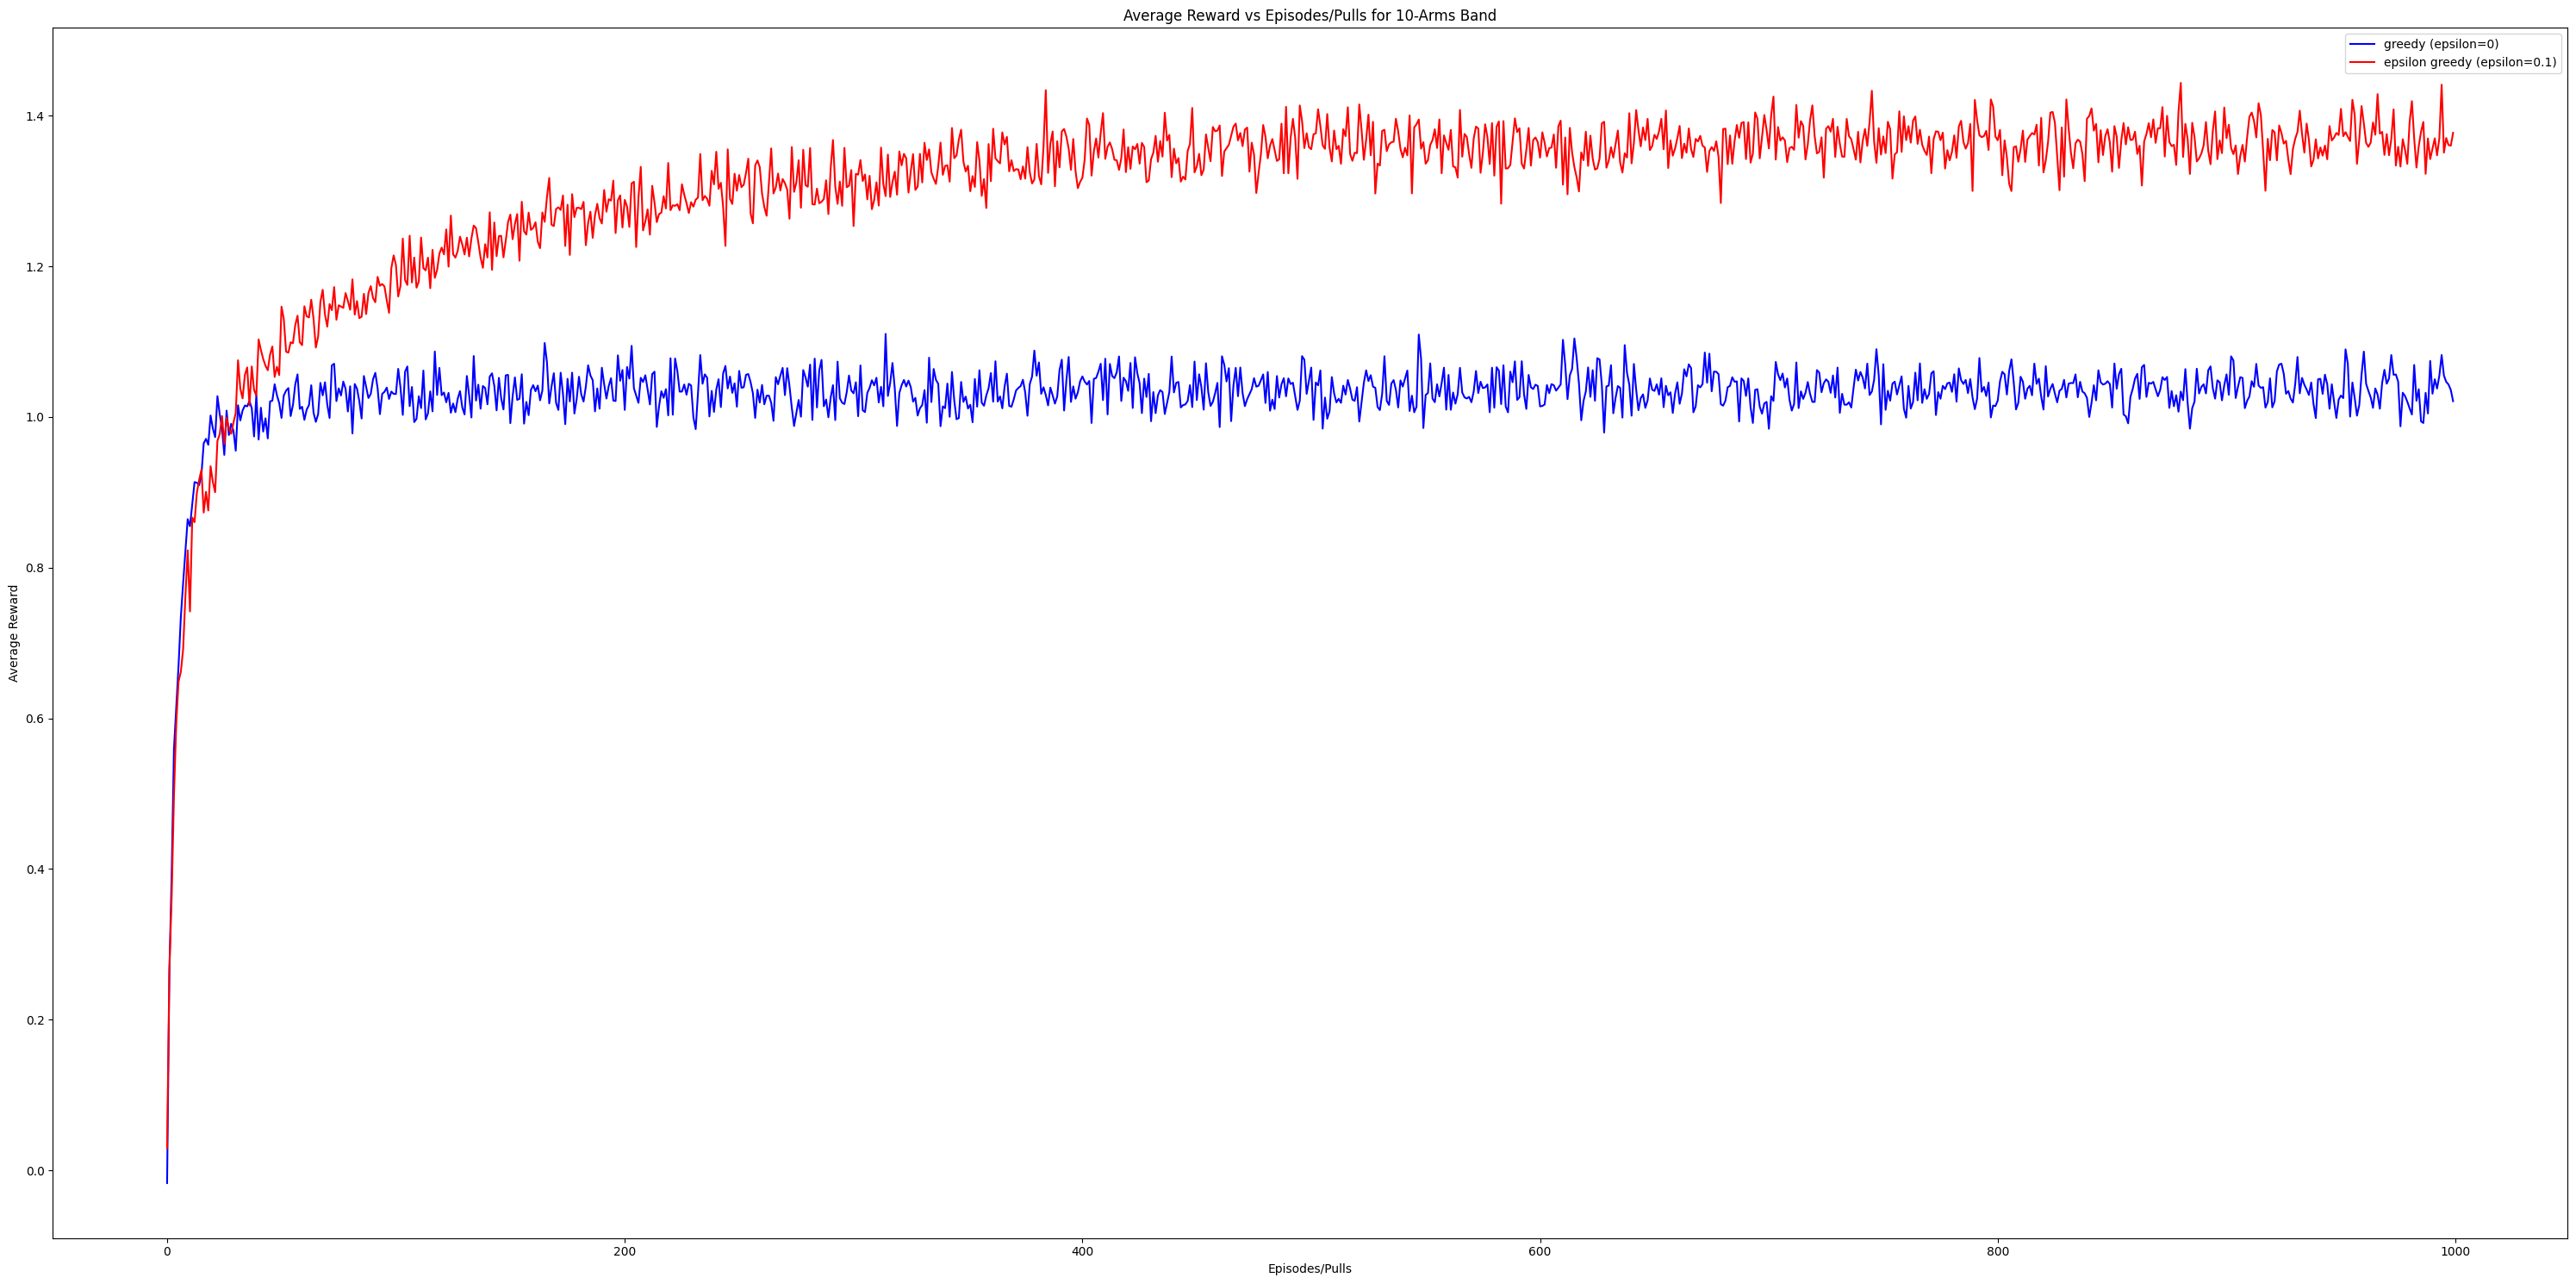

In [17]:
# env = gym.make("BanditTenArmedGaussian-v0")

n_bandits=2000 # number of bandit problems
k=10 # number of arms in each bandit problems
n_episodes=1000 # number of times to pull each arm

greedy_agent_rewards = [0]*n_episodes
epsilon_greedy_agent_rewards = [0]*n_episodes

for bandit in range(n_bandits):
    q_true=np.random.normal(0,1,(k)) # generating the true means q*(a) for each arm for this bandit
    # true_opt_arms=np.argmax(q_true) # the true optimal arms in each bandit

    greedy_agent = GreedyAgent()
    epsilon_greedy_agent = EpsilonGreedyAgent(epsilon = 0.1)

    for pull in range(n_episodes):
        action = greedy_agent.selectAction()
        # if action == true_opt_arms:
            # pass
        r_action_t = np.random.normal(q_true[action],1)
        greedy_agent.updateActionEstimation(action, r_action_t)
        greedy_agent_rewards[pull]+=r_action_t

        action = epsilon_greedy_agent.selectAction()
        r_action_t = np.random.normal(q_true[action],1)
        epsilon_greedy_agent.updateActionEstimation(action, r_action_t)
        epsilon_greedy_agent_rewards[pull]+=r_action_t

avg_greedy_agent_rewards = [x/n_bandits for x in greedy_agent_rewards]
avg_epsilon_greedy_agent_rewards = [x/n_bandits for x in epsilon_greedy_agent_rewards]

fig = plt.figure(figsize = (30, 15))
plt.plot(avg_greedy_agent_rewards, color='blue', label='greedy (epsilon=0)')
plt.plot(avg_epsilon_greedy_agent_rewards, color='red', label='epsilon greedy (epsilon=0.1)')
plt.title("Average Reward vs Episodes/Pulls for 10-Arms Band")
plt.xlabel("Episodes/Pulls")
plt.ylabel("Average Reward")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# # import gym
# # import gym_bandits
# import matplotlib.pyplot as plt

# # env = gym.make("BanditTenArmedGaussian-v0")

# n_bandit=2000 # number of bandit problems
# k=10 # number of arms in each bandit problem
# n_episodes=1000 # number of times to pull each arm

# greedy_agent_rewards = [0]*n_episodes
# epsilon_greedy_agent_rewards = [0]*n_episodes

# for bandit in range(n_bandit):
#     q_true=np.random.normal(0,1,k) # generating the true means q*(a) for each arm for this bandit
#     # true_opt_arms=np.argmax(q_true) # the true optimal arms in each bandit

#     greedy_agent = GreedyAgent()
#     epsilon_greedy_agent = EpsilonGreedyAgent(epsilon = 0.1)

#     for pull in range(n_episodes):
#         action = greedy_agent.selectAction()
#         # if action == true_opt_arms:
#             # pass
#         r_action_t = np.random.normal(q_true[action],1)
#         greedy_agent.updateActionEstimation(action, r_action_t)
#         greedy_agent_rewards[pull]+=r_action_t

#         action = epsilon_greedy_agent.selectAction()
#         r_action_t = np.random.normal(q_true[action],1)
#         epsilon_greedy_agent.updateActionEstimation(action, r_action_t)
#         epsilon_greedy_agent_rewards[pull]+=r_action_t

# # env.reset()
# num_episodes = 1000
# greedy_agent_rewards = []
# for i in range(num_episodes):
#     action = greedy_agent.selectAction()
#     obs, reward, done, info = env.step(action)
#     # print("Took action:", action, "reward:", reward)
#     greedy_agent.updateActionEstimation(action, reward)
#     greedy_agent_rewards.append(reward)

# # env.reset()
# epsilon_greedy_agent_rewards = []
# for i in range(num_episodes):
#     action = epsilon_greedy_agent.selectAction()
#     obs, reward, done, info = env.step(action)
#     # print("Took action:", action, "reward:", reward)
#     epsilon_greedy_agent.updateActionEstimation(action, reward)
#     epsilon_greedy_agent_rewards.append(reward)

# print("Results after", num_episodes, "episodes")
# print("-----------------------------------")
# print("Cumulative reward:")
# print("Greedy:", sum(greedy_agent_rewards), "e_greedy", sum(epsilon_greedy_agent_rewards))
# print("Average rewards:")
# print("Greedy:", sum(greedy_agent_rewards) / len(greedy_agent_rewards), "e_greedy", sum(epsilon_greedy_agent_rewards) / len(epsilon_greedy_agent_rewards))

# figure, axis = plt.subplots(1, 2, figsize=(28, 12))  # Set the figure size to be wider
# axis[0].plot(greedy_agent_rewards)
# axis[0].set_title("Greedy")
# axis[0].set_xlabel("Step/Episode")
# axis[0].set_ylabel("Reward") # the paper uses Average rewards as it completes these 1000 episodes task 2000 times (2000 10-armed bandit situations for each agent to average) 
# axis[1].plot(epsilon_greedy_agent_rewards)
# axis[1].set_xlabel("Step/Episode")
# axis[1].set_ylabel("Reward")
# axis[1].set_title("E-Greedy")
# plt.tight_layout()
# plt.show()

In [18]:
# '''
# ------------------------------
# 10 ARM TESTBED WITH EPS-GREEDY
# ------------------------------
# '''

# import numpy as np
# import matplotlib.pyplot as plt
# import random

# n_bandit=2000 # number of bandit problems
# k=10 # number of arms in each bandit problem
# n_pulls=1000 # number of times to pull each arm

# q_true=np.random.normal(0,1,(n_bandit,k)) # generating the true means q*(a) for each arm for all bandits
# true_opt_arms=np.argmax(q_true,1) # the true optimal arms in each bandit
# # each row represents a bandit problem

# epsilon=[0,0.01,0.1,0.2,1] # epsilon in epsilon-greedy method
# col=['r','g','k','b','y']
# #fig=plt.figure()
# fig1=plt.figure().add_subplot(111)
# fig2=plt.figure().add_subplot(111)

# for eps in range(len(epsilon)) : 

# 	print('Current epsilon : ',eps)

# 	Q=np.zeros((n_bandit,k)) # reward estimated
# 	N=np.ones((n_bandit,k)) # number of times each arm was pulled # each arm is pulled atleast once
# 	Qi=np.zeros((n_bandit,k))
# 	# Pull all arms once
# 	# Qi=np.random.normal(q_true,1) # initial pulling of all arms

# 	R_eps=[]
# 	R_eps.append(0)
# 	R_eps.append(np.mean(Qi))	
# 	R_eps_opt=[]

# 	for pull in range(2,n_pulls+1) :  
# 		R_pull=[] # all rewards in this pull/time-step
# 		opt_arm_pull=0 # number of pulss of best arm in this time step
# 		for i in range(n_bandit) : 	

# 			if random.random()<epsilon[eps] : 
# 				j=np.random.randint(k)											
# 			else : 
# 				j=np.argmax(Q[i])

# 			if j==true_opt_arms[i] : # To calculate % optimal action
# 				opt_arm_pull=opt_arm_pull+1

# 			temp_R=np.random.normal(q_true[i][j],1)
# 			R_pull.append(temp_R)
# 			N[i][j]=N[i][j]+1
# 			Q[i][j]=Q[i][j]+(temp_R-Q[i][j])/N[i][j]
		
# 		avg_R_pull=np.mean(R_pull)		
# 		R_eps.append(avg_R_pull)
# 		R_eps_opt.append(float(opt_arm_pull)*100/2000)
# 	fig1.plot(range(0,n_pulls+1),R_eps,col[eps])
# 	fig2.plot(range(2,n_pulls+1),R_eps_opt,col[eps])

# plt.rc('text',usetex=True)
# #plt.ylim(0.5,1.5)
# fig1.title.set_text(r'$\epsilon$-greedy : Average Reward Vs Steps for 10 arms')
# fig1.set_ylabel('Average Reward')
# fig1.set_xlabel('Steps')
# fig1.legend((r"$\epsilon=$"+str(epsilon[0]),r"$\epsilon=$"+str(epsilon[1]),r"$\epsilon=$"+str(epsilon[2]),r"$\epsilon=$"+str(epsilon[3]),r"$\epsilon=$"+str(epsilon[4])),loc='best')
# fig2.title.set_text(r'$\epsilon$-greedy : $\%$ Optimal Action Vs Steps for 10 arms')
# fig2.set_ylabel(r'$\%$ Optimal Action')
# fig2.set_xlabel('Steps')
# fig2.set_ylim(0,100)
# fig2.legend((r"$\epsilon=$"+str(epsilon[0]),r"$\epsilon=$"+str(epsilon[1]),r"$\epsilon=$"+str(epsilon[2]),r"$\epsilon=$"+str(epsilon[3]),r"$\epsilon=$"+str(epsilon[4])),loc='best')
# plt.show()

In [ ]:
# # import gym
# # import gym_bandits
# import matplotlib.pyplot as plt
# import numpy as np

# # env = gym.make("BanditTenArmedGaussian-v0")

# n_bandit=2000 # number of bandit problems
# k=10 # number of arms in each bandit problems
# n_episodes=1000 # number of times to pull each arm

# # greedy_agent_rewards = [0]*n_episodes
# # epsilon_greedy_agent_rewards = [0]*n_episodes

# q_true = np.random.normal(0,1,(n_bandit,k))
# Q = np.zeros((n_bandit,k)) # reward estimated
# N = np.zeros((n_bandit,k)) # number of times each arm was pulled # each arm is pulled atleast once
# # Qi= np.zeros((n_bandit,k)) # initial pulling of all arms

# greedy_agents = []
# for i in range(n_bandits):
#     greedy_agents.append(GreedyAgent())

# greedy_agent_rewards = []

# greedy_agent_rewards.append(0)

# for pull in range(1, n_episodes):
#     R_pull_greedy = []
#     for i in range(n_bandits):
#         j = np.argmax(Q[i])
        
#         # action_greedy = greedy_agents[i].selectAction()
#         # r_action_t_greedy = np.random.normal(q_true[i][action_greedy],1)
#         # greedy_agents[i].updateActionEstimation(action_greedy, r_action_t_greedy)
#         r_action_t_greedy = np.random.normal(q_true[i][j],1)
#         R_pull_greedy.append(r_action_t_greedy)
        
#         N[i][j]=N[i][j]+1
#         Q[i][j]=Q[i][j]+(r_action_t_greedy-Q[i][j]) / N[i][j]

#     avg_R_pull_greedy=np.mean(R_pull_greedy)	
#     greedy_agent_rewards.append(avg_R_pull_greedy)

# fig = plt.figure(figsize = (30, 15))
# plt.plot(greedy_agent_rewards, color='blue', label='greedy (epsilon=0)')
# plt.title("Average Reward vs Episodes/Pulls for 10-Arms Band")
# plt.xlabel("Episodes/Pulls")
# plt.ylabel("Average Reward")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # for bandit in range(n_bandits):
# #     # q_true=np.random.normal(0,1,(k)) # generating the true means q*(a) for each arm for this bandit
# #     # true_opt_arms=np.argmax(q_true) # the true optimal arms in each bandit

# #     greedy_agent = GreedyAgent()
# #     epsilon_greedy_agent = EpsilonGreedyAgent(epsilon = 0.1)

# #     for pull in range(n_episodes):
# #         action = greedy_agent.selectAction()
# #         # if action == true_opt_arms:
# #             # pass
# #         r_action_t = np.random.normal(q_true[action],1)
# #         greedy_agent.updateActionEstimation(action, r_action_t)
# #         greedy_agent_rewards[pull]+=r_action_t

# #         action = epsilon_greedy_agent.selectAction()
# #         r_action_t = np.random.normal(q_true[action],1)
# #         epsilon_greedy_agent.updateActionEstimation(action, r_action_t)
# #         epsilon_greedy_agent_rewards[pull]+=r_action_t

# # avg_greedy_agent_rewards = [x/n_bandits for x in greedy_agent_rewards]
# # avg_epsilon_greedy_agent_rewards = [x/n_bandits for x in epsilon_greedy_agent_rewards]

# # fig = plt.figure(figsize = (30, 15))
# # plt.plot(avg_greedy_agent_rewards, color='blue', label='greedy (epsilon=0)')
# # plt.plot(avg_epsilon_greedy_agent_rewards, color='red', label='epsilon greedy (epsilon=0.1)')
# # plt.title("Average Reward vs Episodes/Pulls for 10-Arms Band")
# # plt.xlabel("Episodes/Pulls")
# # plt.ylabel("Average Reward")
# # plt.legend()
# # plt.tight_layout()
# # plt.show()

# **Stationary vs Non-Stationary Problems**

The problems we've discussed so far involve stationary rewards, where the reward distributions do not change over time. Most reinforcement learning problems, however, have *nonstationary rewards* — the reward distributions change over time.

The problem with sample averaging is that "action-value estimations are heavily based on rewards from an old distribution" [source](https://medium.com/@numsmt2/reinforcement-learning-chapter-2-multi-armed-bandits-part-3-nonstationary-problems-5dae437e13c2).

"We’d like to be flexible to a changing reward distribution such that when the distribution changes, we can quickly learn which actions are now good to take and which actions are no longer good to take". We can achieve this using a constant alpha instead of a changing step-size parameter (1/n).
With a changing step-size parameter, "As an action is chosen more and more α shrinks causing increasingly smaller changes to the estimation of the value for that action". With a fixed step-size parameter, alpha, "If an action that used to give a reward suddenly stops giving rewards, α will cause the estimation of that action’s value to quickly diminish".

# **Upper-Confidence Bound Algorithm**

Instead of randomly 'exploring' actions with some probability epsilon, we look towards a new method where we select actions with a preference for the actions that we are less confident about.

UCB is defined using the following formula:

[![](https://miro.medium.com/v2/resize:fit:1026/format:webp/1*tJaQ4fERl3A69CMcqefSTw.png)](https://miro.medium.com/v2/resize:fit:1026/format:webp/1*tJaQ4fERl3A69CMcqefSTw.png)

Qt(a) is the estimated value of the action, while the right term is an expression of the uncertainty of what the reward will be for any given action (which is a function of how many times that action has been selected).
The "parameter c (constant between 0 and 1) can be be considered as determining the degree of exploration. Higher c values cause greater exploration because they cause the uncertainty about actions to be larger".

## **Implementation**

We now implement UCB using a similar structure to what we did before (but we set it here as a stationary problem). We set c = 2.

In [26]:
class UCBAgent(MultiArmedBanditsAgent):
    """
	Implementation of an agent that uses a changing step-size parameter
	for action-value estimation and Upper-Confidence-Bound action
	selection.
	env: Gym env the agent will be trained on
	c: confidence value
	"""
    def __init__(self, c, env=None):
        super().__init__(env)
        self.c = c

    def selectAction(self, t):
        """
        select an action using the UCB algorithm
        """
        ucb_values=[]
        for action in self.actions:
            uncertainty=None
            if action.n == 0:
                uncertainty = float("inf") # for numerical stability
            else:
                uncertainty = self.c * np.sqrt(np.log(t)/action.n)

            ucb_values.append(action.Q + uncertainty)

        return np.argmax(ucb_values)

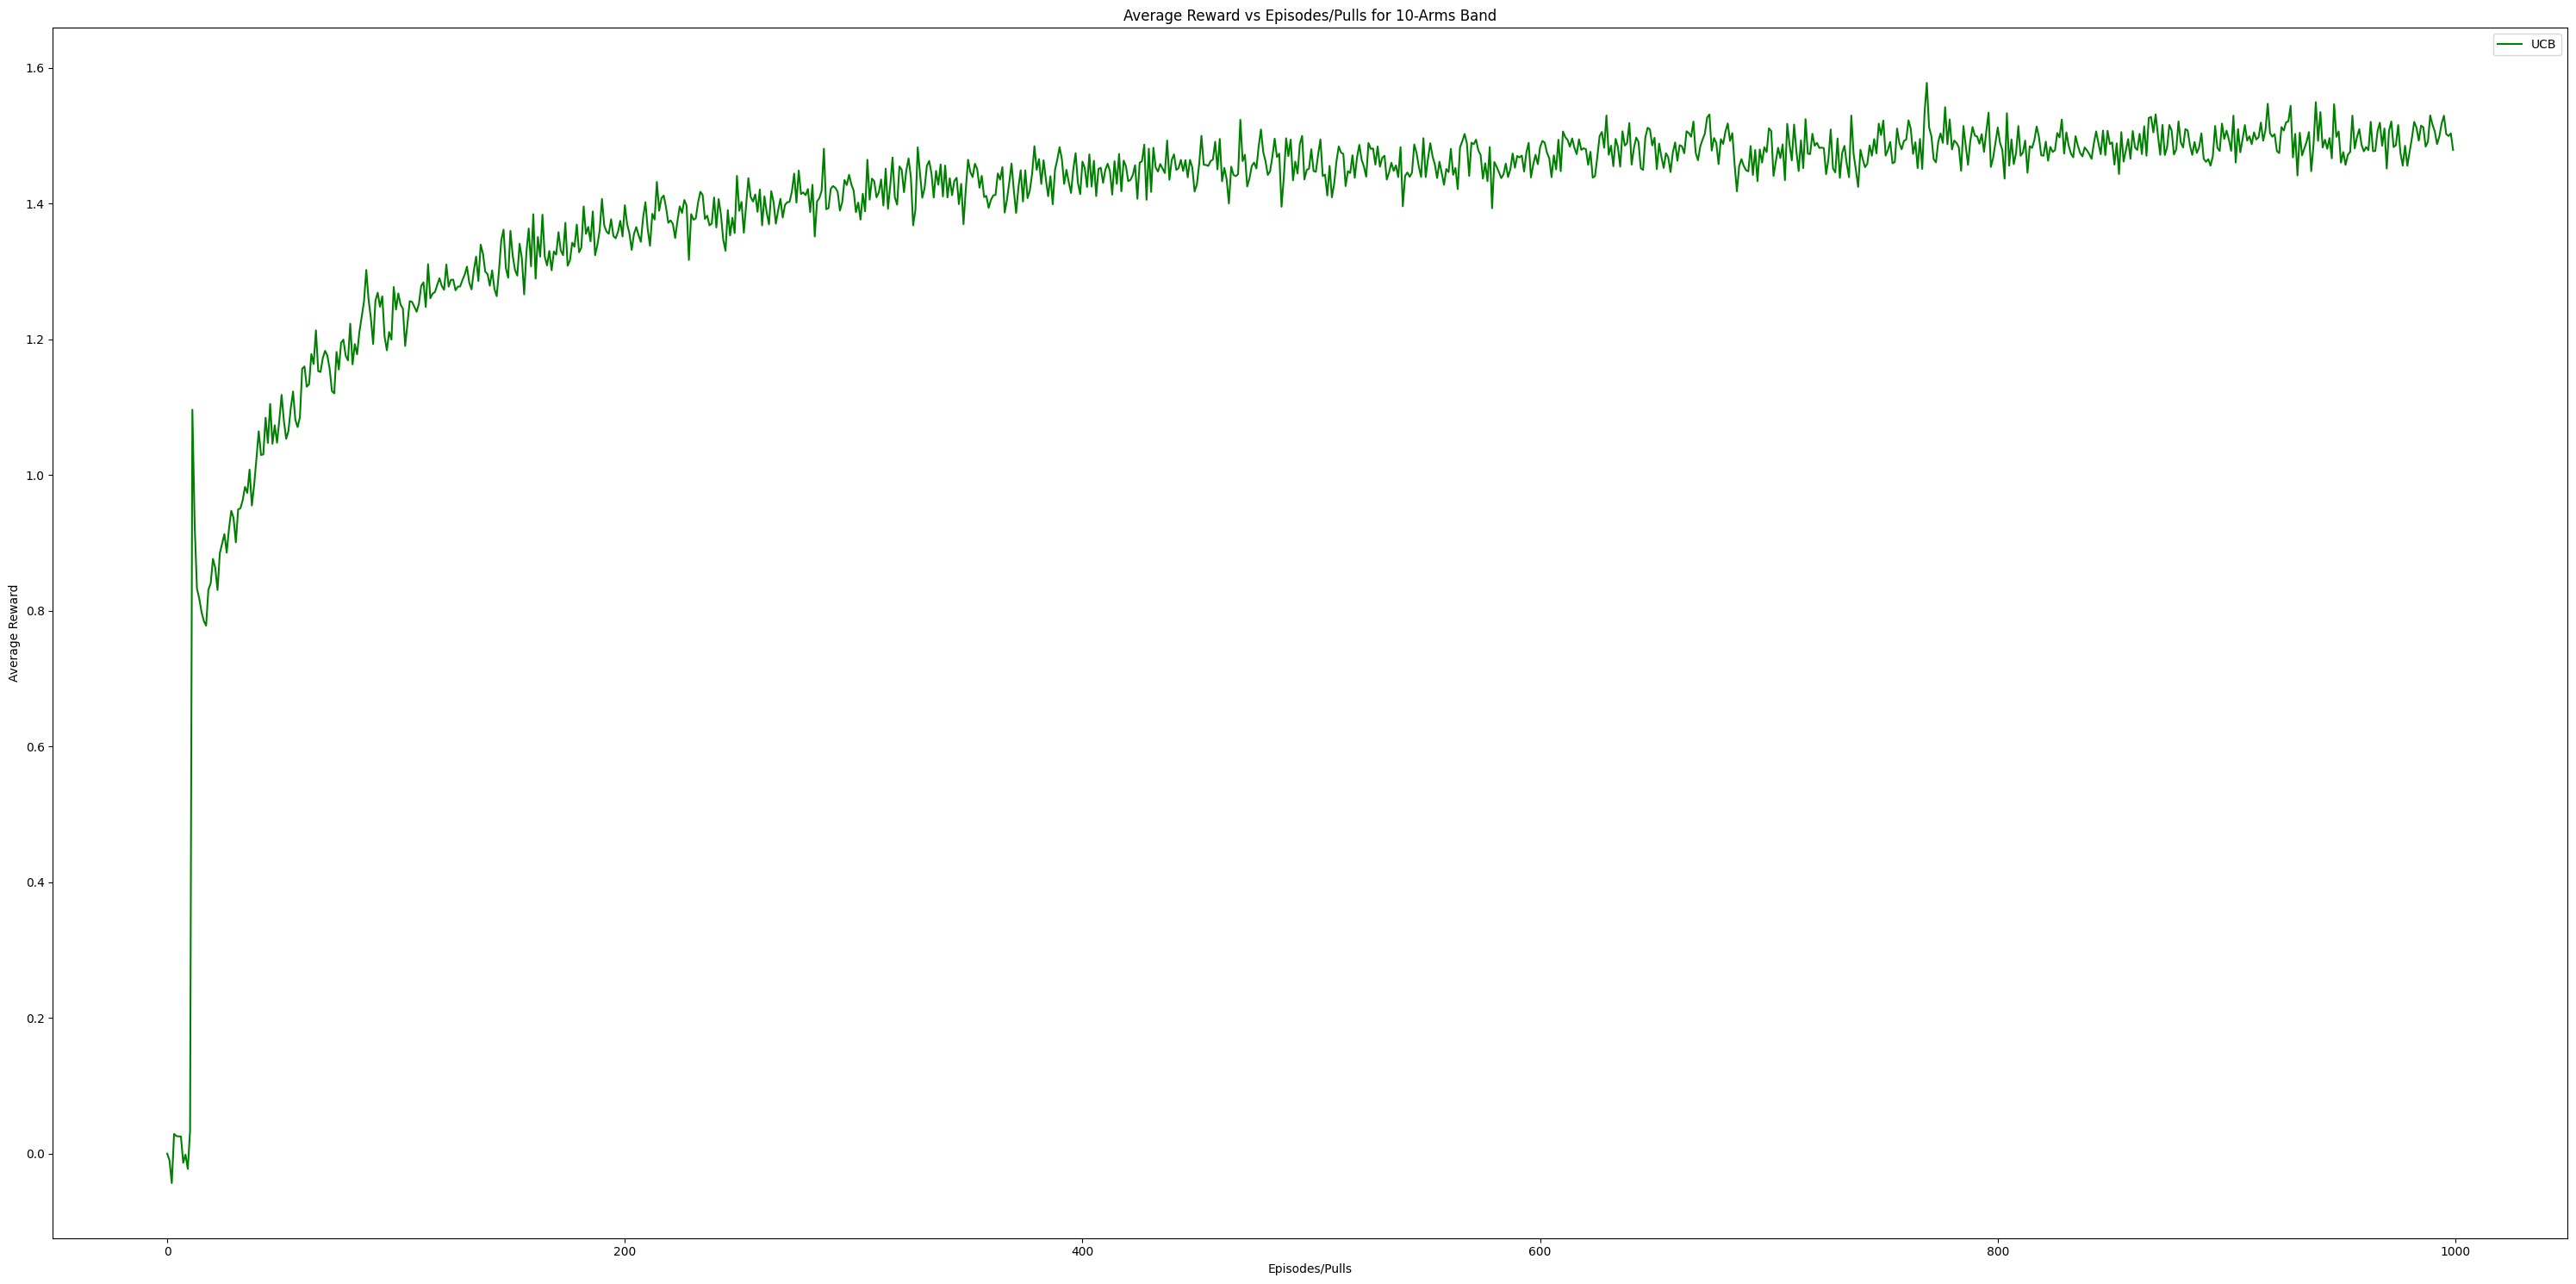

In [28]:
n_bandits=2000 # number of bandit problems
k=10 # number of arms in each bandit problems
n_episodes=1000 # number of times to pull each arm

ucb_agent_rewards = [0]*n_episodes

for bandit in range(n_bandits):
    q_true=np.random.normal(0,1,(k)) # generating the true means q*(a) for each arm for this bandit

    ucb_agent = UCBAgent(c=2)

    for pull in range(1,n_episodes):
        action = ucb_agent.selectAction(pull)
        r_action_t = np.random.normal(q_true[action],1)
        ucb_agent.updateActionEstimation(action, r_action_t)
        ucb_agent_rewards[pull]+=r_action_t

avg_ucb_agent_rewards = [x/n_bandits for x in ucb_agent_rewards]

fig = plt.figure(figsize = (30, 15))
plt.plot(avg_ucb_agent_rewards, color='green', label='UCB')
plt.title("Average Reward vs Episodes/Pulls for 10-Arms Band")
plt.xlabel("Episodes/Pulls")
plt.ylabel("Average Reward")
plt.legend()
plt.tight_layout()
plt.show()

# **Gradient Bandits**

As opposed to "action-value methods that estimate the value of actions, gradient bandit methods don’t care about the value of an action but rather learn a preference for each action over another. This preference has no interpretation in terms of reward. only the relative preference over other actions matters".

The probability of selecting any action is given by the following:

[![](https://miro.medium.com/v2/resize:fit:1016/format:webp/1*AX0W2iBa_zWgr_Jt__s6Jw.png)](https://miro.medium.com/v2/resize:fit:1016/format:webp/1*AX0W2iBa_zWgr_Jt__s6Jw.png)

Thus, each "action will be given a probability of being selected and the probabilities of all those actions will sum to 1".

The value Hₜ(a) represents the preference of selecting an action a over the other actions. On each step, after selecting the action Aₜ and receiving the reward Rₜ, the action preferences are updated:

[![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*bDrWLSSX5dWn3FTkvDFKig.png)](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*bDrWLSSX5dWn3FTkvDFKig.png)

We present the preference update for the action just taken and the preference updates for all other actions.

α > 0 is a step-size parameter that determines the degree to which the preferences are changed at each step

R¯ₜ or “R mean at timestep t” is the average of all the rewards from all timesteps including timestep t for Aₜ. Similar to previous methods, this can be updated using incremental updates with the sample-averaging method or a constant-α parameter that is better suited for nonstationary rewards.
R¯ₜ can be thought of as a baseline against which the current reward is compared. If the reward is higher than the baseline, then the preference for this action is increased. If the reward is lower than the baseline, then vice-versa. The trick is that this baseline is across all different actions (as per [forum](https://stats.stackexchange.com/questions/324973/gradient-bandit-algorithm-baseline))

The bottom part of the equation moves the preferences for all other actions in the opposite direction.

## **Implementation**

We present an implementation that parallels our former working.

In [10]:
class GradientBanditAgent(MultiArmedBanditsAgent):
    def __init__(self, alpha, env=None):
        super().__init__(env)

        self.H_values = [0] * len(self.actions)
        self.alpha = alpha
        self.r_mean = 0 # baseline
        self.t = 0

    def selectAction(self):
        self.action_probs = list(map(self._getActionProb, self.H_values))

        # Select an action randomly **using the weighted probabilities**
        action = random.choices(list(range(len(self.actions))), self.action_probs, k=1)[0]

        return action

    def _getActionProb(self, H): # Helper
        """
        Gets the probability of selecting an action using a softmax over the action preferences
        """
        return np.exp(H) / np.sum(np.exp(self.H_values))
        

    def updateActionPreferences(self, action, reward):
        # Update action estimation using incrementally updated sample averaging
        self.t+=1
        self.r_mean = self.r_mean + (1.0/self.t) * (reward - self.r_mean)
        
        error = reward - self.r_mean

        for a in list(range(len(self.actions))):
            if a != action:
                self._updateActionPreference(a, error)
            else:
                self._updateActionPreference(a, error, is_curr_action=True)
    
    def _updateActionPreference(self, action, error, is_curr_action=False): # Helper
        action_pref = self.H_values[action]
        action_prob = self.action_probs[action]
        
        if is_curr_action:
            self.H_values[action] = action_pref + self.alpha*error*(1-action_prob)
        else:
            self.H_values[action] = action_pref - self.alpha*error*action_prob

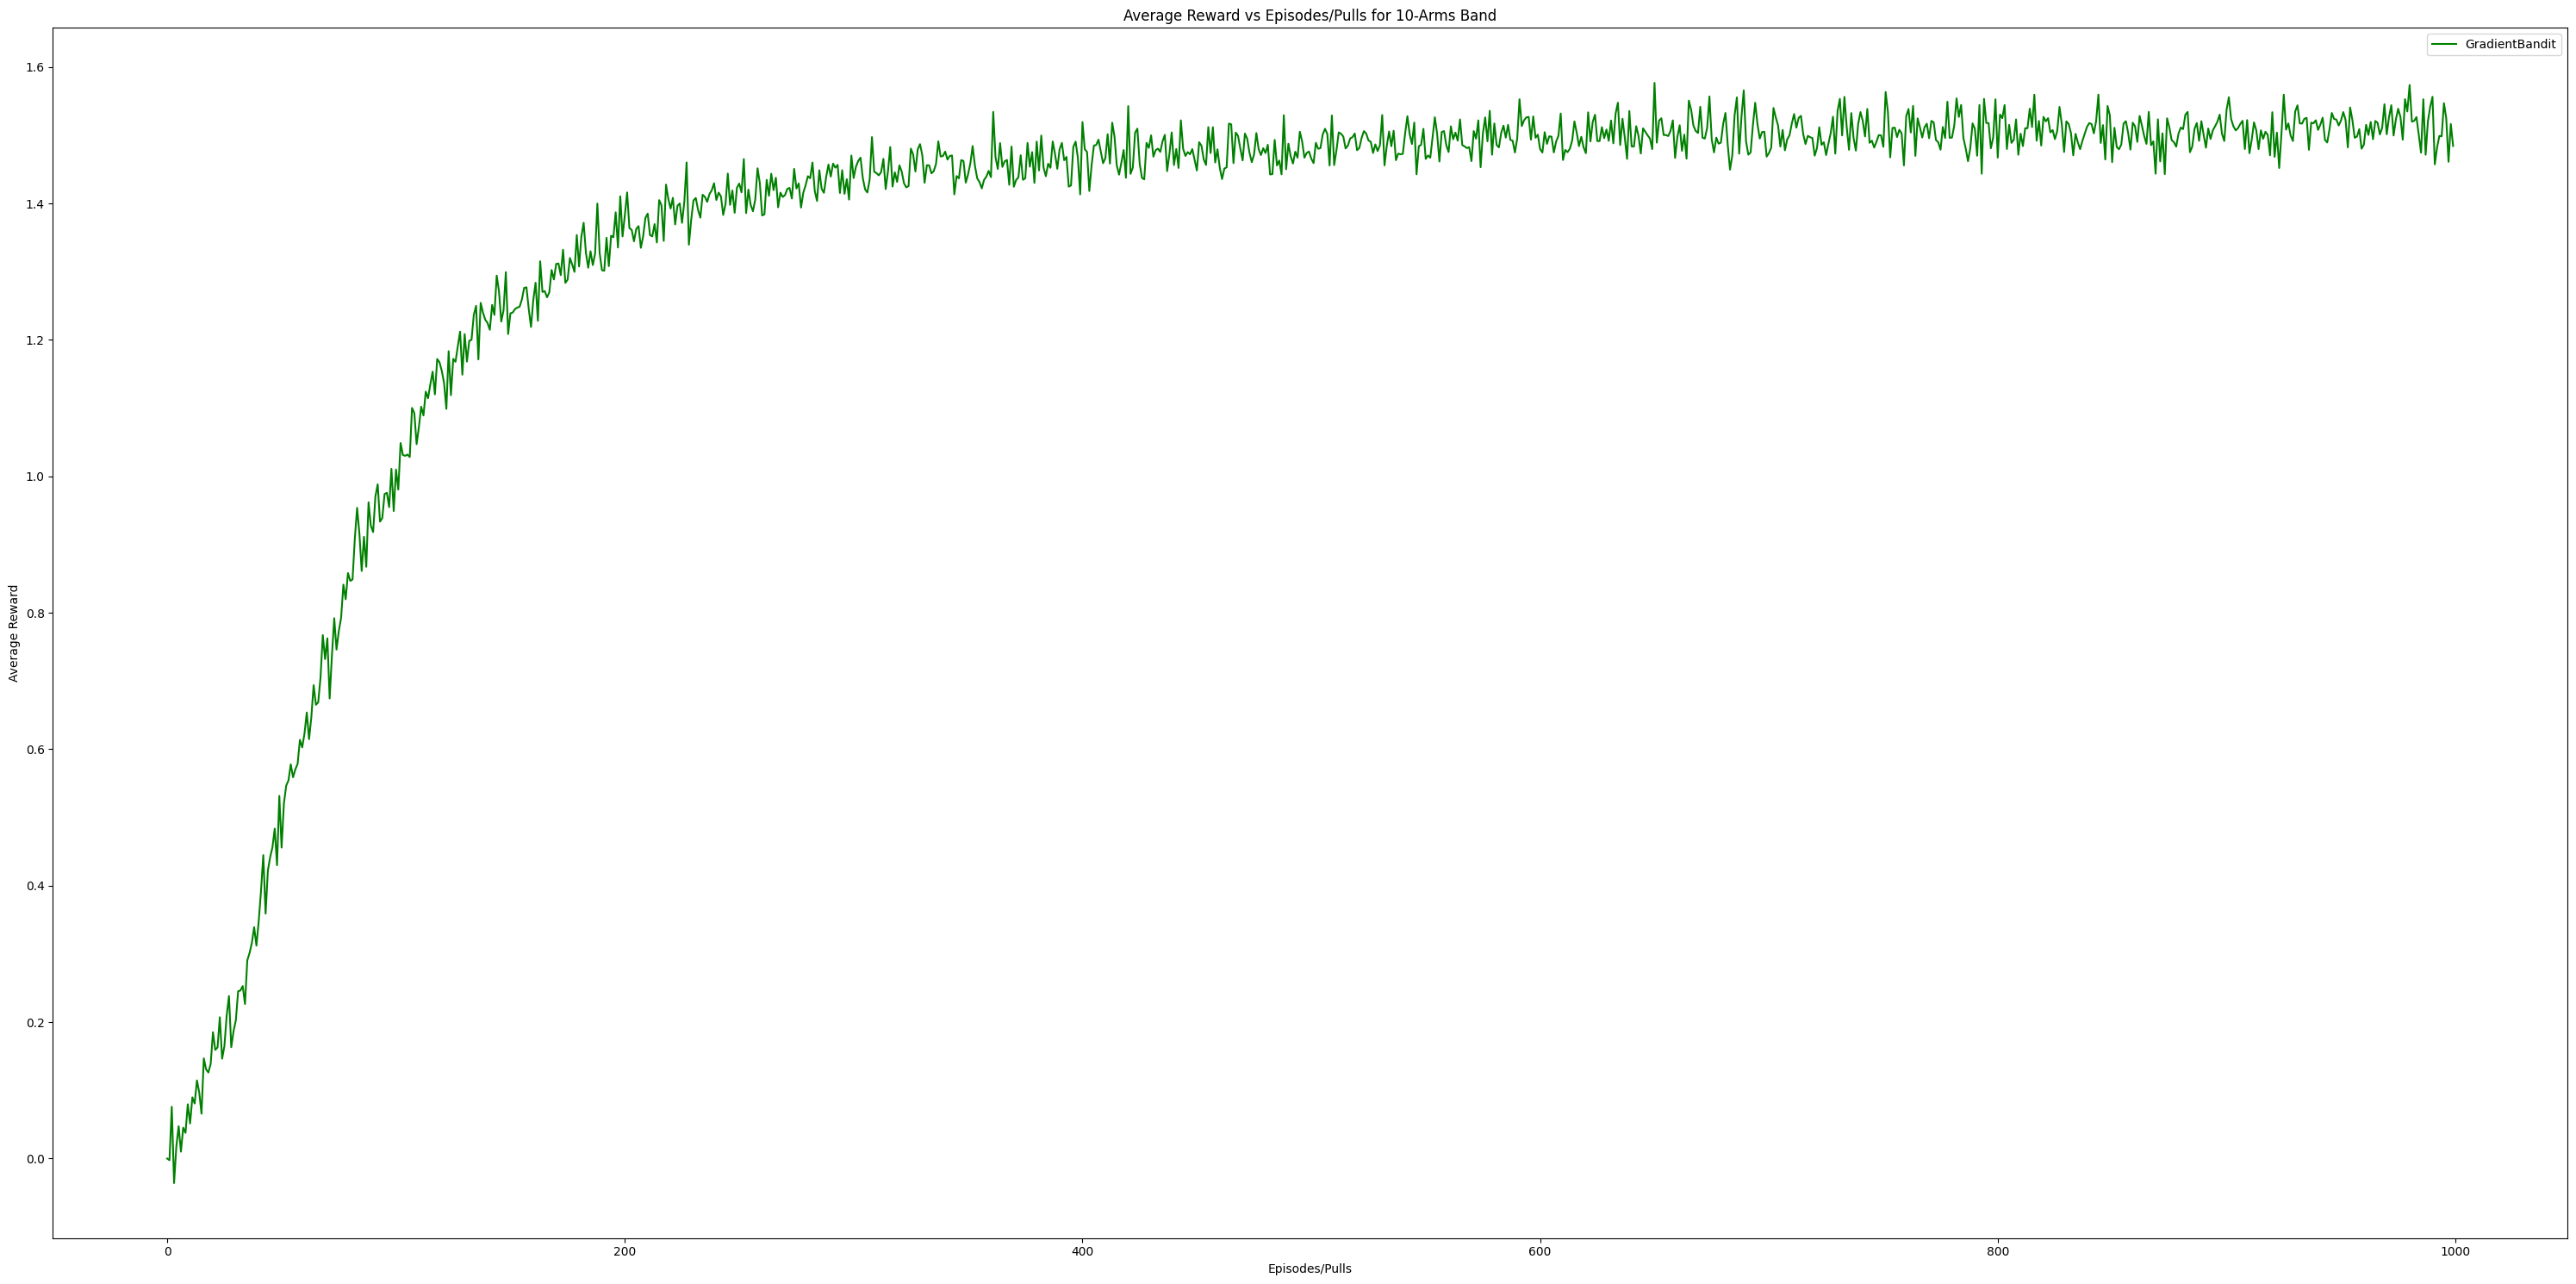

In [11]:
n_bandits=2000 # number of bandit problems
k=10 # number of arms in each bandit problems
n_episodes=1000 # number of times to pull each arm

gradientbandit_agent_rewards = [0]*n_episodes

for bandit in range(n_bandits):
    q_true=np.random.normal(0,1,(k)) # generating the true means q*(a) for each arm for this bandit

    gradient_bandit_agent = GradientBanditAgent(alpha=0.1, env=None)

    for pull in range(1,n_episodes):
        action = gradient_bandit_agent.selectAction()
        r_action_t = np.random.normal(q_true[action],1)
        gradient_bandit_agent.updateActionPreferences(action, r_action_t)
        gradientbandit_agent_rewards[pull]+=r_action_t

avg_gradientbandit_agent_rewards = [x/n_bandits for x in gradientbandit_agent_rewards]

fig = plt.figure(figsize = (30, 15))
plt.plot(avg_gradientbandit_agent_rewards, color='green', label='GradientBandit')
plt.title("Average Reward vs Episodes/Pulls for 10-Arms Band")
plt.xlabel("Episodes/Pulls")
plt.ylabel("Average Reward")
plt.legend()
plt.tight_layout()
plt.show()